# 17 - SIFT SfM Class Pipeline

Notebook mit `SFM_Sift` als sauberem, erweiterbarem Wrapper fuer Dataset-Load, Prediction, Validation und Submission-Export.

In [1]:
from pathlib import Path
import sys

import pandas as pd

def find_project_root() -> Path:
    candidates = [Path.cwd(), Path.cwd().parent, Path('.').resolve(), Path('..').resolve()]
    seen = set()
    for cand in candidates:
        root = cand.resolve()
        key = str(root)
        if key in seen:
            continue
        seen.add(key)
        if (root / 'data' / 'data').exists():
            return root
    raise FileNotFoundError('Could not find project root containing data/data.')

PROJECT_ROOT = find_project_root()
SRC_ROOT = PROJECT_ROOT / 'src'
if str(SRC_ROOT) not in sys.path:
    sys.path.insert(0, str(SRC_ROOT))

from gdloc import SFM_Sift, SIFTSFMConfig

DATA_ROOT = PROJECT_ROOT / 'data' / 'data'

print('project_root:', PROJECT_ROOT)
print('src_root:', SRC_ROOT)
print('data_root:', DATA_ROOT)


project_root: /home/dev/workspace/gnss-denied-localization
src_root: /home/dev/workspace/gnss-denied-localization/src
data_root: /home/dev/workspace/gnss-denied-localization/data/data


In [2]:
cfg = SIFTSFMConfig(
    image_max_side=1000,
    preprocess_mode='gray_clahe',
    sift_nfeatures=6500,
    sift_contrast_thr=0.03,
    sift_edge_thr=12.0,
    sift_sigma=1.6,
    sift_ratio_thr=0.78,
)

sfm = SFM_Sift(
    train_images=DATA_ROOT / 'train_data' / 'train_images',
    test_images=DATA_ROOT / 'test_data' / 'test_images',
    train_cam_csv=DATA_ROOT / 'train_data' / 'train_cam.csv',
    test_cam_csv=DATA_ROOT / 'test_data' / 'test_cam.csv',
    train_pos_csv=DATA_ROOT / 'train_data' / 'train_pos.csv',
    map_path=DATA_ROOT / 'map.png',
    config=cfg,
)


In [3]:
sfm.load_dataset()

print('train frames:', len(sfm.train_ids))
print('test frames:', len(sfm.test_ids))
print('test ranges:', sfm.test_ranges)

if sfm.calib_df is not None:
    display(sfm.calib_df.head(10))
if sfm.coef_df is not None:
    display(sfm.coef_df)


train frames: 305
test frames: 136
test ranges: [(1, 12), (42, 44), (53, 56), (65, 68), (2468, 2527), (2663, 2674), (2705, 2716), (2747, 2758), (2789, 2800), (2832, 2836)]


,id0,id1,matches,affine_inliers,sfm_inliers,success,gt_dx,gt_dy,tx,ty,rot_deg,scale
0,13,14,889,520,717,True,12.100219,282.643468,-1.536253,-365.835768,0.342588,0.971274
1,14,15,1033,673,1022,True,11.402862,283.176780,-14.654605,-367.882534,0.126208,0.973838
2,15,16,1383,992,1379,True,10.308909,281.614690,-20.898145,-371.819701,-0.266982,0.974243
3,16,17,1025,825,1017,True,10.226597,281.633158,-11.978889,-374.084956,0.232232,0.975204
4,18,17,1260,1112,1260,True,-11.233083,-282.616440,16.418855,386.366170,0.125598,1.021478
5,19,18,709,370,709,True,317.838775,-190.268070,1371.545484,593.736623,-176.773370,0.954110
6,20,19,847,472,845,True,9.277163,292.793237,-7.851393,382.954440,0.873273,1.026391
7,21,20,1550,1146,1550,True,11.742709,281.338696,-13.534233,382.993838,-0.193955,1.024071
8,22,23,1008,794,569,True,-10.686914,-281.641056,11.958885,-370.926137,-0.077997,0.975694
9,23,24,1252,1117,1250,True,-11.641880,-283.359286,13.319208,-381.464254,0.168534,0.977629


,dx_coef,dy_coef
tx,0.047887,-0.049737
ty,-0.093533,0.060236
rot_rad,-58.792652,-2.003406
log_scale,-1443.052266,2778.654371
sfm_tx,-20.950985,18.289418
sfm_ty,7.742996,-2.182200
sfm_tz,5.436568,-31.523241
bias,-0.654353,5.468173


In [4]:
segment_diag_df = sfm.forward_test_set()

if sfm.plan_df is not None:
    display(sfm.plan_df)
display(segment_diag_df)
if sfm.step_diag_df is not None:
    display(sfm.step_diag_df.head(40))


,segment_idx,start_id,end_id,length,anchor_train_id,direction,closing_train_id,prev_train_id,next_train_id,entry_inliers_forward,entry_inliers_backward
0,0,1,12,12,13,backward,NaN,NaN,13.0,NaN,NaN
1,1,42,44,3,41,forward,45.0,41.0,45.0,624.0,960.0
2,2,53,56,4,52,forward,57.0,52.0,57.0,830.0,703.0
3,3,65,68,4,64,forward,69.0,64.0,69.0,412.0,1281.0
4,4,2468,2527,60,2528,backward,72.0,72.0,2528.0,2.0,655.0
5,5,2663,2674,12,2662,forward,2675.0,2662.0,2675.0,2958.0,2139.0
6,6,2705,2716,12,2704,forward,2717.0,2704.0,2717.0,2010.0,2894.0
7,7,2747,2758,12,2746,forward,2759.0,2746.0,2759.0,2994.0,2710.0
8,8,2789,2800,12,2788,forward,2801.0,2788.0,2801.0,2516.0,2414.0
9,9,2832,2836,5,2831,forward,NaN,2831.0,NaN,NaN,NaN


,segment_idx,start_id,end_id,direction,anchor_train_id,closing_train_id,closure_used,closure_inliers,closure_err_x,closure_err_y,closure_err_norm
0,0,1,12,backward,13,NaN,False,0,0.000000,0.000000,0.000000
1,1,42,44,forward,41,45.0,True,913,-425.405823,477.454705,639.478780
2,2,53,56,forward,52,57.0,True,759,-263.570809,694.343365,742.685855
3,3,65,68,forward,64,69.0,True,1446,-267.054740,639.288701,692.826297
4,4,2468,2527,backward,2528,72.0,False,4,0.000000,0.000000,0.000000
5,5,2663,2674,forward,2662,2675.0,True,2140,-204.784906,-379.324346,431.072867
6,6,2705,2716,forward,2704,2717.0,True,2823,-287.464502,-258.787556,386.790433
7,7,2747,2758,forward,2746,2759.0,True,2762,-181.498303,-479.366842,512.576046
8,8,2789,2800,forward,2788,2801.0,True,2502,-149.373223,-598.463622,616.823367
9,9,2832,2836,forward,2831,NaN,False,0,0.000000,0.000000,0.000000


,segment_idx,step_idx,source_id,target_id,direction,predict_mode,matches,affine_inliers,sfm_inliers,pred_dx,pred_dy,pred_x,pred_y
0,0,0,13,12,backward,model,715,381,412,-214.930715,2.454050,2357.807282,289.386360
1,0,1,12,11,backward,model,679,404,365,-75.735287,129.239134,2282.071996,418.625494
2,0,2,11,10,backward,model,977,632,976,-57.005380,88.217772,2225.066616,506.843266
3,0,3,10,9,backward,model,1331,1036,547,-70.823312,70.887938,2154.243304,577.731204
4,0,4,9,8,backward,model,1242,955,664,-79.786890,88.061679,2074.456413,665.792883
5,0,5,8,7,backward,model,890,550,884,-84.352089,105.585871,1990.104325,771.378754
6,0,6,7,6,backward,model,1049,669,467,214.625748,-38.598039,2204.730073,732.780715
7,0,7,6,5,backward,model,1239,1076,1228,-78.909635,98.862170,2125.820438,831.642885
8,0,8,5,4,backward,model,1765,1515,1602,-62.266345,110.968794,2063.554093,942.611679
9,0,9,4,3,backward,model,944,673,640,-62.607306,64.366361,2000.946787,1006.978040


In [5]:
submission_path = PROJECT_ROOT / 'build' / 'submission_17_sfm_sift_class.csv'
submission_df = sfm.export_submission_csv(submission_path)

print('saved:', submission_path)
display(submission_df.head(20))
display(submission_df.tail(20))


saved: /home/dev/workspace/gnss-denied-localization/build/submission_17_sfm_sift_class.csv


,id,x_pixel,y_pixel
0,1,1859.083749,1165.114125
1,2,1935.501737,1071.034128
2,3,2000.946787,1006.978040
3,4,2063.554093,942.611679
4,5,2125.820438,831.642885
5,6,2204.730073,732.780715
6,7,1990.104325,771.378754
7,8,2074.456413,665.792883
8,9,2154.243304,577.731204
9,10,2225.066616,506.843266


,id,x_pixel,y_pixel
116,2756,2721.222888,793.548800
117,2757,2704.227967,801.487404
118,2758,2677.194385,774.520939
119,2789,2675.646583,515.234140
120,2790,2675.671028,476.961290
121,2791,2677.060899,438.171479
122,2792,2645.669098,422.196568
123,2793,2644.691172,386.552657
124,2794,2606.146054,388.651662
125,2795,2685.098824,481.324400


In [6]:
# Optional validation on a train interval
val_df = sfm.forward_range_validation(2568, 2580)
display(val_df.head(20))
display(val_df.tail(20))


Validation range [2568, 2580] | train frames=12 | mean_err=630.72px | median_err=652.61px


,source_id,target_id,target_is_train,direction,predict_mode,matches,affine_inliers,sfm_inliers,pred_dx,pred_dy,pred_x,pred_y,gt_x,gt_y,err_px
0,2568,2569,True,forward,model,1968,1857,1962,15.576676,7.855501,2181.833899,1820.268620,2163.786244,1724.032328,97.913950
1,2569,2570,True,forward,model,2150,1959,2149,-14.712634,22.708520,2167.121265,1842.977140,2160.941703,1634.790282,208.278551
2,2570,2571,True,forward,model,2793,2660,1719,1.604364,40.525192,2168.725629,1883.502332,2158.037147,1553.564718,330.110698
3,2571,2572,True,forward,model,3195,3126,3193,31.091028,-8.104345,2199.816658,1875.397987,2153.841593,1464.712726,413.250638
4,2572,2573,True,forward,model,3735,3710,3734,29.314475,-6.044592,2229.131133,1869.353395,2149.536866,1383.197384,492.628577
5,2573,2574,True,forward,model,3582,3575,726,12.190873,27.552864,2241.322006,1896.906259,2145.046132,1295.907416,608.661361
6,2574,2575,True,forward,model,3448,3427,3038,19.774589,0.375222,2261.096595,1897.281481,2141.125555,1211.127382,696.563349
7,2575,2576,True,forward,model,3258,3230,1985,14.967518,-25.365115,2276.064113,1871.916367,2138.045301,1128.722713,755.900787
8,2576,2577,True,forward,model,2692,2646,2690,-5.663323,1.260510,2270.400790,1873.176876,2134.730032,1043.141664,841.049943
9,2577,2578,True,forward,model,2351,2263,2341,13.509882,7.731547,2283.910671,1880.908423,2131.526887,958.186871,935.219696


,source_id,target_id,target_is_train,direction,predict_mode,matches,affine_inliers,sfm_inliers,pred_dx,pred_dy,pred_x,pred_y,gt_x,gt_y,err_px
0,2568,2569,True,forward,model,1968,1857,1962,15.576676,7.855501,2181.833899,1820.268620,2163.786244,1724.032328,97.913950
1,2569,2570,True,forward,model,2150,1959,2149,-14.712634,22.708520,2167.121265,1842.977140,2160.941703,1634.790282,208.278551
2,2570,2571,True,forward,model,2793,2660,1719,1.604364,40.525192,2168.725629,1883.502332,2158.037147,1553.564718,330.110698
3,2571,2572,True,forward,model,3195,3126,3193,31.091028,-8.104345,2199.816658,1875.397987,2153.841593,1464.712726,413.250638
4,2572,2573,True,forward,model,3735,3710,3734,29.314475,-6.044592,2229.131133,1869.353395,2149.536866,1383.197384,492.628577
5,2573,2574,True,forward,model,3582,3575,726,12.190873,27.552864,2241.322006,1896.906259,2145.046132,1295.907416,608.661361
6,2574,2575,True,forward,model,3448,3427,3038,19.774589,0.375222,2261.096595,1897.281481,2141.125555,1211.127382,696.563349
7,2575,2576,True,forward,model,3258,3230,1985,14.967518,-25.365115,2276.064113,1871.916367,2138.045301,1128.722713,755.900787
8,2576,2577,True,forward,model,2692,2646,2690,-5.663323,1.260510,2270.400790,1873.176876,2134.730032,1043.141664,841.049943
9,2577,2578,True,forward,model,2351,2263,2341,13.509882,7.731547,2283.910671,1880.908423,2131.526887,958.186871,935.219696


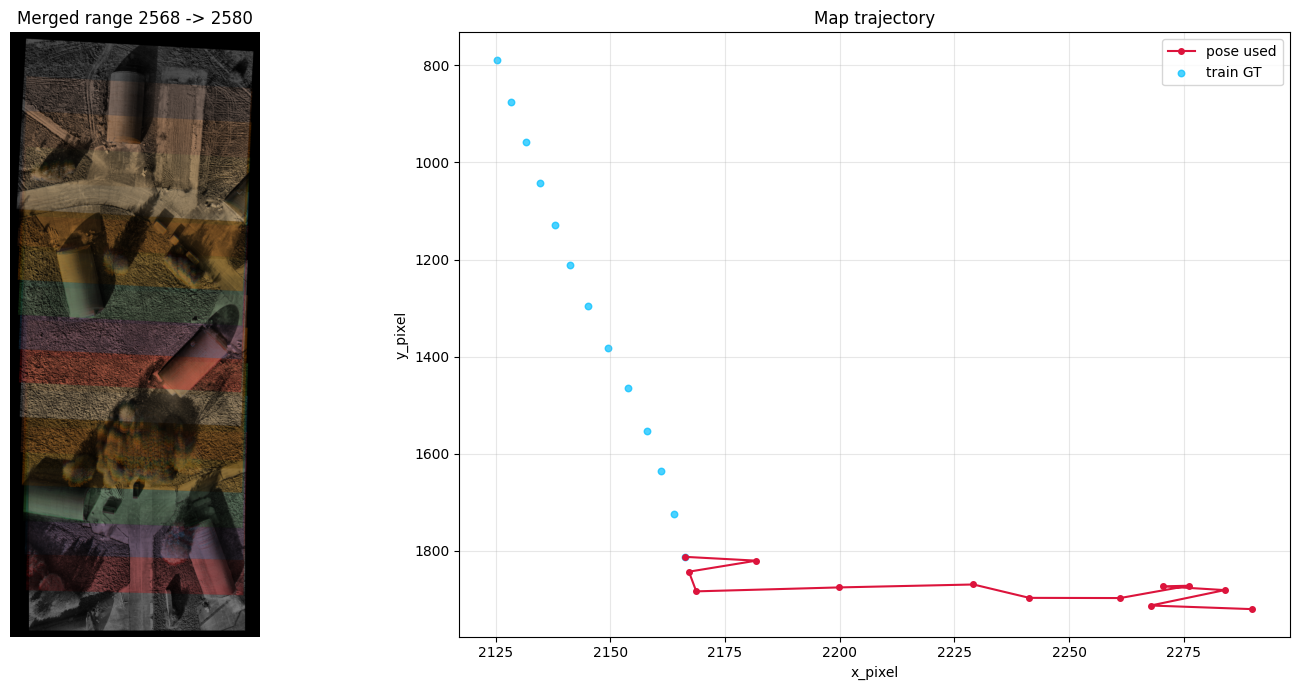

In [7]:
# Optional merged overlay visualization
sfm.plot_range(2568, 2580, validation=True)
